In [ ]:
!pip install jax
!pip install distrax
!pip install tensorflow
!pip install tensorflow-probability
!pip install git+https://github.com/Habush/blackjax.git

In [ ]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import blackjax
import networkx as nx
import itertools
import numpyro
import torch
from tensorflow_probability.substrates import jax as tfp
import time
tfd = tfp.distributions
%load_ext autoreload

/home/xabush/miniconda3/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [ ]:
def jax_prng_key():
    return jax.random.PRNGKey(np.random.randint(int(1e5)))

In [ ]:
rng_key = jax.random.PRNGKey(0)

In [ ]:
import igraph as ig
dim = 4
lattice_dim = 2
g = ig.Graph.Lattice(dim=[dim, dim])
J = np.asarray(g.get_adjacency().data)
p = J.shape[1]
eta = 0.1
mu = 0.2
J.shape

(16, 16)

In [ ]:
J

array([[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]])

In [ ]:

quadfun = lambda x, A: jnp.dot(x, jnp.dot(A, x))
def get_gt_mean(J, mu):
  dim = J.shape[1]**2
  # b = jnp.full(dim, mu)
  ar = jnp.array([-1., 1.])[None]
  ar_dup = jnp.repeat(ar, p, axis=0)
  arg = [ar_dup[i] for i in range(ar_dup.shape[0])]
  lst = jnp.array(list(itertools.product([-1.0, 1.0], repeat=dim)))
  print(lst.shape)
  f = lambda x: jnp.exp(jnp.sum((x @ J * x), axis=-1) + jnp.sum(mu*x, axis=-1))
  flst = jax.jit(f)(lst)
  plst = flst/jnp.sum(flst)
  gt_mean = jnp.sum(plst.reshape(-1, lst.shape[1]), axis=0)
  return gt_mean

# def get_gt_mean(J, eta, mu):
#   dim = J.shape[1]**2
#   lst = jnp.array(list(itertools.product([-1.0, 1.0], repeat=dim)))
#   f = lambda x: jnp.exp(eta*jnp.sum(x @ J * x, axis=-1) + jnp.sum(mu*x, axis=-1))
#   flst = jax.jit(f)(lst)
#   plst = flst/jnp.sum(flst)


def get_log_rmse(x, gt_mean):
  x = 2. * x - 1
  return jnp.log(jnp.sqrt(jnp.mean((x - gt_mean)**2)))

def inference_loop(rng_key, kernel, initial_state, num_samples):
  @jax.jit
  def one_step(state, rng_key):
    state, _ = kernel(rng_key, state)
    return state, state

  keys = jax.random.split(rng_key, num_samples)
  _, states = jax.lax.scan(one_step, initial_state, keys)

  return states


def inference_loop_multiple_chains(rng_key, kernel, initial_state, num_samples, num_chains):
  
  def one_step(states, rng_key):
    keys = jax.random.split(rng_key, num_chains)
    states, _ = jax.vmap(kernel)(keys, states)
    return states, states

  keys = jax.random.split(rng_key, num_samples)
  _, states = jax.lax.scan(one_step, initial_state, keys)

  return states 

def get_ess(chain, burn_in):
    c = chain
    l = c.shape[0]
    bi = int(burn_in * l)
    c = c[bi:]
    cv = tfp.mcmc.effective_sample_size(c)
    cv = cv.at[jnp.isnan(cv)*1].set(1.)
    return cv

In [ ]:
# gt_mean = get_gt_mean(J, mu)
gt_mean = jnp.array([0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800,
        0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800, 0.4800])

In [ ]:
def logprob_fn(theta, J, eta, mu):
  x = (2 * theta) - 1
  xg = x @ J
  xgx = jnp.sum((xg * x), axis=-1)
  return eta*xgx + mu*jnp.sum(x)

logprob = lambda x: logprob_fn(x, J, eta, mu)
grad_fn = jax.grad(logprob)

In [ ]:
# %autoreload
# import blackjax
# import distrax
num_test = 1
num_chains = 2
num_samples = 10000
step_size = 0.2
cat_dist = tfd.Bernoulli(probs=[0.5]*p)
init_pos = cat_dist.sample(seed=jax_prng_key()) * 1.
init_state = blackjax.dmala.init(init_pos, logprob)
dmala = blackjax.dmala(logprob, step_size)
dmala_kernel = jax.jit(dmala.step)
init_state

MALAState(position=DeviceArray([1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
             0.], dtype=float32, weak_type=True), logprob=DeviceArray(-0.4, dtype=float32), logprob_grad=DeviceArray([ 1.2,  1.2, -0.4,  1.2,  0.4,  0.4,  1.2,  0.4,  1.2,  0.4,
             -0.4,  0.4,  0.4,  0.4,  1.2,  0.4],            dtype=float32, weak_type=True))

In [ ]:
keys = jax.random.split(rng_key, num_samples)
print_every = 10
chain = np.zeros((num_samples, p))
viz_every = 1000
time_list = []
times = []
rmses = []
mean = np.zeros(p)
cur_time = 0.

cur_state = init_state

for i in range(num_samples):
  key = keys[i]
  st = time.time()
  cur_state, _ = dmala_kernel(key, cur_state)
  cur_time += time.time() - st

  x = cur_state.position
  chain[i] = x
  mean = mean + x
  if i % viz_every == 0:
    time_list.append(cur_time)
    rmse = get_log_rmse(mean / (i+1), gt_mean)
    rmses.append(rmse)

  if i % print_every == 0:
    times.append(cur_time)
    # print("=", end="")

mean = mean / num_samples

In [ ]:
rmses

[DeviceArray(0.05236013, dtype=float32),
 DeviceArray(-2.5134761, dtype=float32),
 DeviceArray(-2.7733402, dtype=float32),
 DeviceArray(-2.7359052, dtype=float32),
 DeviceArray(-2.8884366, dtype=float32),
 DeviceArray(-2.9066622, dtype=float32),
 DeviceArray(-2.7770133, dtype=float32),
 DeviceArray(-2.746789, dtype=float32),
 DeviceArray(-3.008416, dtype=float32),
 DeviceArray(-3.0751057, dtype=float32)]

In [ ]:
chain.shape

(10000, 16)

In [ ]:

ess = get_ess(chain, 0.1)
print("ess = {} +/- {}".format(ess.mean(), ess.std()))

ess = 576.8231201171875 +/- 171.40316772460938


/home/xabush/miniconda3/lib/python3.9/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:282: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa3c81e3c40>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa3c839e610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa3c82700d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa3c839e6d0>],
 'fliers': [],
 'means': []}

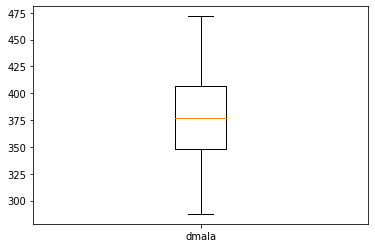

In [ ]:
plt.boxplot([ess / times[-1] / (1. - 0.1)], labels=["dmala"], showfliers=False)

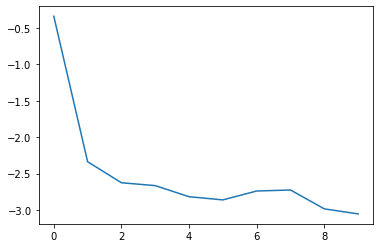

In [ ]:
plt.plot(rmses)

In [ ]:
states = inference_loop(rng_key, dmala_kernel, init_state, num_samples)
states.position.block_until_ready()
states = blackjax.mcmc.mala.MALAState(np.squeeze(states.position).squeeze(), 
                                  states.logprob, states.logprob_grad)

### Experiments with Categorical Distribution

In [ ]:
def diff_fn_multi_dim(theta, theta_delta, step_size):
    return jax.tree_util.tree_map(lambda x_cur, x_delta, g_cur: 0.5*g_cur*(x_delta - x_cur)
                                                          - 0.5*((x_delta - x_cur)**2)*step_size,
                            theta.position, theta_delta.position, theta.logprob_grad)


In [ ]:
def mix(A, n_out, sigma):
    off_diag = -(jnp.ones((n_out, n_out)) - jnp.eye(n_out)) * sigma
    diag = jnp.eye(n_out) * sigma
    return off_diag + diag

def forward(x, dim, n_out, G, bias, sigma):

    assert list(x.shape[1:]) == [dim ** 2, n_out]
    xr = x.reshape(-1, n_out)
    print(xr.shape)
    xr_mix = (xr @ mix(A, n_out, sigma)).reshape(x.shape[0], -1, n_out)
    TEST = jnp.einsum("aik,ij->ajk", xr_mix, G)
    TEST2 = jnp.einsum("aik,aik->a", TEST, x)

    indep = jnp.sum(jnp.sum((x * bias[None]), axis=-1), axis=-1)
    # return pairwise + indep
    return TEST2 + indep

logprob = lambda x: jnp.sum(forward(x, dim, n_out, A, bias, sigma), axis=0)
grad_fn = jax.value_and_grad(logprob)

In [ ]:
import igraph as ig
from blackjax.mcmc.diffusion import DiffusionState, overdamped_langevin
dim = 2
n_out = 3
sigma = 0.1
integrator = overdamped_langevin(grad_fn)
g = ig.Graph.Lattice(dim=[dim, dim], circular=True)  # Boundary conditions
A = jnp.asarray(g.get_adjacency().data)  
bias = jnp.ones((dim**2, n_out))
init_dist = tfd.OneHotCategorical(logits=bias)
s1 = init_dist.sample(seed=jax_prng_key(), sample_shape=(1,)) * 1.
s2 = init_dist.sample(seed=jax_prng_key(), sample_shape=(1,)) * 1.
assert not jnp.allclose(s1, s2)

/home/xabush/miniconda3/lib/python3.9/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:105: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.argmax(np.expand_dims(logits, -1) + z, axis=-2).astype(dtype)


In [ ]:

val1, grad1 = grad_fn(s1)
ds1 = DiffusionState(s1, val1, grad1)
ds2 = integrator(rng_key, ds1, 1e-3)

(4, 3)
(4, 3)
(4, 3)


In [ ]:
s1

DeviceArray([[[0., 0., 1.],
              [0., 0., 1.],
              [0., 1., 0.],
              [1., 0., 0.]]], dtype=float32, weak_type=True)

In [ ]:
forward_logits = diff_fn_multi_dim(ds1, ds2, 1e-3).reshape(s1.shape[0], -1)
cd_forward = tfd.OneHotCategorical(logits=forward_logits)
changes = cd_forward.sample(seed=rng_key)
changes

/home/xabush/miniconda3/lib/python3.9/site-packages/tensorflow_probability/python/internal/backend/jax/random_generators.py:105: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.argmax(np.expand_dims(logits, -1) + z, axis=-2).astype(dtype)


DeviceArray([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [ ]:
changes_r = changes.reshape(s1.shape)
change_ind = jnp.sum(changes_r, axis=-1)
s2 = s1*(1. - change_ind[:,:,None]) + changes_r
val2, grad2 = grad_fn(s2)
ds2 = DiffusionState(s2, val2, grad2)
reverse_logits = diff_fn_multi_dim(ds2, ds1, 1e-3).reshape(s2.shape[0], -1)
cd_reverse = tfd.OneHotCategorical(logits=reverse_logits)
reverse_changes = (s1 * change_ind[:,:,None]).reshape(s2.shape[0], -1)


(4, 3)


In [ ]:
lp_forward = cd_forward.log_prob(changes)
lp_reverse = cd_reverse.log_prob(reverse_changes)
m_term = (jnp.squeeze(val2 - val1))
la = jnp.exp(m_term)
u = jax.random.uniform(jax_prng_key(), shape=(la.shape))

In [ ]:
a = la > u

In [ ]:
s2*a[None,None,None] + s1*(1. - a[None, None, None])

DeviceArray([[[1., 0., 0.],
              [0., 0., 1.],
              [0., 1., 0.],
              [1., 0., 0.]]], dtype=float32, weak_type=True)

In [ ]:
a[...,None][None][None]

DeviceArray([[[ True]]], dtype=bool)